<h1>IMDb Reviews Sentiment Analysis using RNN</h1>

Welcome to the notebook!<br>
We'll be performing sentiment analysis on the [IMDb reviews dataset](https://www.dropbox.com/s/bjk9tydkqrza8p8/IMDb_Reviews.csv?dl=1) with 86% accuracy.<br>
<br>
Let's get started by importing the necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
print(tf.__version__)
"""from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession"""

2.3.0


'from pyspark import SparkContext, SparkConf\nfrom pyspark.sql import SparkSession'

Let's download the dataset and create a pandas dataframe out of it.

In [2]:
df = pd.read_csv("https://www.dropbox.com/s/bjk9tydkqrza8p8/IMDb_Reviews.csv?dl=1")
df.head()

,review,sentiment
0,My family and I normally do not watch local mo...,1
1,"Believe it or not, this was at one time the wo...",0
2,"After some internet surfing, I found the ""Home...",0
3,One of the most unheralded great works of anim...,1
4,"It was the Sixties, and anyone with long hair ...",0


Now that we have the dataframe, our next task is to split the data into *training* and *validation data*.<br>
<br>
Here we split the data into 0.7 and 0.3 fractions of the dataset respecitvely.<br>
Note that we need to make sure the data is balanced. Hence, we apply the **stratify** method on the sentiment column of the dataframe. 

In [3]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, test_size=0.3, shuffle=True, random_state=2, stratify=df.sentiment)

In [4]:
print(train_data['sentiment'].value_counts())
print('-'*100)
print(test_data['sentiment'].value_counts())

1    17500
0    17500
Name: sentiment, dtype: int64
----------------------------------------------------------------------------------------------------
1    7500
0    7500
Name: sentiment, dtype: int64


Hence we verified that both the sets are balanced.<br>
<br>
Now we start off with **data transformation** where we format the data in a way the model can utilise.<br>
We start by creating two numpy arrays for each set - one array for sentences and the other array for the labels.

In [5]:
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

training_sentences = np.array(train_data['review'])
testing_sentences = np.array(test_data['review'])

training_labels = np.array(train_data['sentiment'])
testing_labels = np.array(test_data['sentiment'])

Here we focus on two important steps we take regarding **feature engineering**:


1.   Tokenization
2.   Padding

###Tokenization
The process involves building a word index dictionary which tokenizes each word in the training set i.e. we index every unique word in the training dataset.<br>
We also define a character \<OOV\> which will replace all the words that are not in the top 20000 recurring words in the word index.
<br>
###Padding
Every sentence in the dataset would not have the same number of words obviously. Now this is a problem because neural networks expect a fixed input size.<br>
We overcome this problem by keeping a fixed input size of 150 and pad the shorter sentences such that they possess the same shape. Also, we have set the truncation type to *post* which means, when it comes to sentences longer than 150 words, only the first 150 words would be taken into account and the rest of the words would simply be trimmed off.

In [6]:
vocab_size = 20000
embedding_dim = 16
max_length = 150
trunc_type='post'
oov_tok = "<OOV>"

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length)

Let's verify our code by printing the indices of a couple of random words.

In [7]:
print(word_index['hello'])
print(word_index['awesome'])

5056
1166


Now let's verify the padding process by printing the indices of a sentence without and with padding respectively.

In [8]:
print(sequences[1])

[181, 799, 17, 3745, 97, 5, 12, 561, 692, 13, 2, 113, 14, 11388, 76, 133, 150, 627, 197, 4, 50, 118, 2, 1025, 14, 881, 220, 10, 91, 23, 528, 138, 11, 502, 379, 23, 49, 2, 476, 109, 14, 374, 11, 90, 121, 117, 34, 165, 41, 535, 769, 244, 37, 12, 3, 140, 62, 9873, 1, 1, 308, 12, 7, 3745, 207, 9, 7, 2511]


In [9]:
print(padded[1])

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0   181   799
    17  3745    97     5    12   561   692    13     2   113    14 11388
    76   133   150   627   197     4    50   118     2  1025    14   881
   220    10    91    23   528   138    11   502   379    23    49     2
   476   109    14   374    11    90   121   117    34   165    41   535
   769   244    37    12     3   140    62  9873     1     1   308    12
     7  3745   207     9     7  2511]


Looks perfect!
<br><br>
Now let's find a way to get the sentence from the padded indices sequences! This can be accomplished by having a reverse word index which has the indices as the keys and the corresponding words as the values.

In [10]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[1]))
print('-'*100)
print(training_sentences[1])

? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? quite typical for swedish movies of this type strange that the acting was soooo bad these actors usually give a good show the casting was poorly done it made you expect something i won't tell you what the lead character was awful i don't know where they find her anyway stay away from this and go see den <OOV> <OOV> instead this is swedish action in is prime
----------------------------------------------------------------------------------------------------
Quite typical for swedish movies of this type. Strange that the acting was soooo bad, these actors usually give a good show. The casting was poorly done, it made you expect something (I won't tell you what). The lead character was awful... I don't know where they find her. Anyway, stay away from this and go see "Den Tredje Vågen" instead, this is swedish action in is prime

We can compare the original sentence with the decoded sentence and notice the padding and the removal of punctuations.
<br>
<br>
Now let's move ahead to defining and training the model. 
<br>
I'm gonna create a custom callback which stops training the model when the training accuracy reaches 95%.

In [11]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95):
      print("\nReached 95.0% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback() 

Alright let's build the model!<br>
The layers are as follows:


1.   An Embedding layer
2.   A bi-directional LSTM layer with 128 units
3.   A bi-directional LSTM layer with 32 units
4.   A dense layer with 6 units and ReLU activation
5.   Output layer with a single dense unit with sigmoid activation for binary classification 

The model is using *Adam* as the optimizer with a learning rate of 0.002 (which was determined using the *learning rate scheduler* as the optimum one. Also, the model uses *binary_crossentropy* which is the de-facto standard for binary classification.
Let's measure the performance of the model with *accuracy* as the metric.



In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    #tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(lr=2e-3)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()




Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 16)           320000    
_________________________________________________________________
bidirectional (Bidirectional (None, 150, 256)          148480    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                73984     
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 542,861
Trainable params: 542,861
Non-trainable params: 0
_________________________________________________________________


In [13]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-3 * 10**(epoch / 20))

In [14]:
num_epochs = 50
history = model.fit(padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), callbacks=[
                                                                                                                             #lr_schedule, 
                                                                                                                             callbacks])

Epoch 1/50
1094/1094 [==============================] - 41s 37ms/step - loss: 0.6851 - accuracy: 0.5441 - val_loss: 0.6448 - val_accuracy: 0.6497
Epoch 2/50
1094/1094 [==============================] - 40s 37ms/step - loss: 0.6269 - accuracy: 0.6444 - val_loss: 0.5318 - val_accuracy: 0.7566
Epoch 3/50
1094/1094 [==============================] - 40s 36ms/step - loss: 0.4482 - accuracy: 0.8051 - val_loss: 0.3654 - val_accuracy: 0.8506
Epoch 4/50
1094/1094 [==============================] - 40s 36ms/step - loss: 0.3099 - accuracy: 0.8811 - val_loss: 0.3223 - val_accuracy: 0.8708
Epoch 5/50
1094/1094 [==============================] - 40s 36ms/step - loss: 0.2233 - accuracy: 0.9216 - val_loss: 0.3317 - val_accuracy: 0.8682
Epoch 6/50
1094/1094 [==============================] - 40s 37ms/step - loss: 0.1626 - accuracy: 0.9480 - val_loss: 0.3745 - val_accuracy: 0.8664
Epoch 7/50
1093/1094 [============================>.] - ETA: 0s - loss: 0.1256 - accuracy: 0.9628
Reached 95.0% accuracy so 

We notice the model stops training with 96.28% training accuracy and 85.89% test accuracy.

In [15]:
import matplotlib.pyplot as plt
"""
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-3, 2e-3, 0, 2])"""

'\nplt.semilogx(history.history["lr"], history.history["loss"])\nplt.axis([1e-3, 2e-3, 0, 2])'

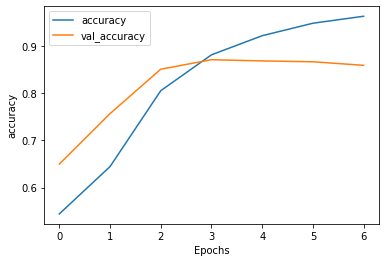

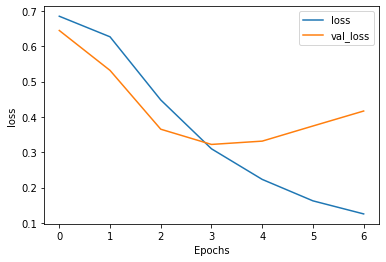

In [16]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

We notice two things:


*   The validation accuracy curve flattens with the third epoch whereas the training accuracy keeps increasing.
*   The validation loss starts increasing after the third-fourth epoch whereas the training loss keeps decreasing

This suggests that our model is overfitting!<br>
But, I am going to leave it here since 86% accuracy is pretty decent.
<br>
Let us now visualise the trained weights of the model using the [Embedding projector](https://projector.tensorflow.org/) provided by TensorFlow.




In [17]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) 

(20000, 16)


In [18]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [23]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

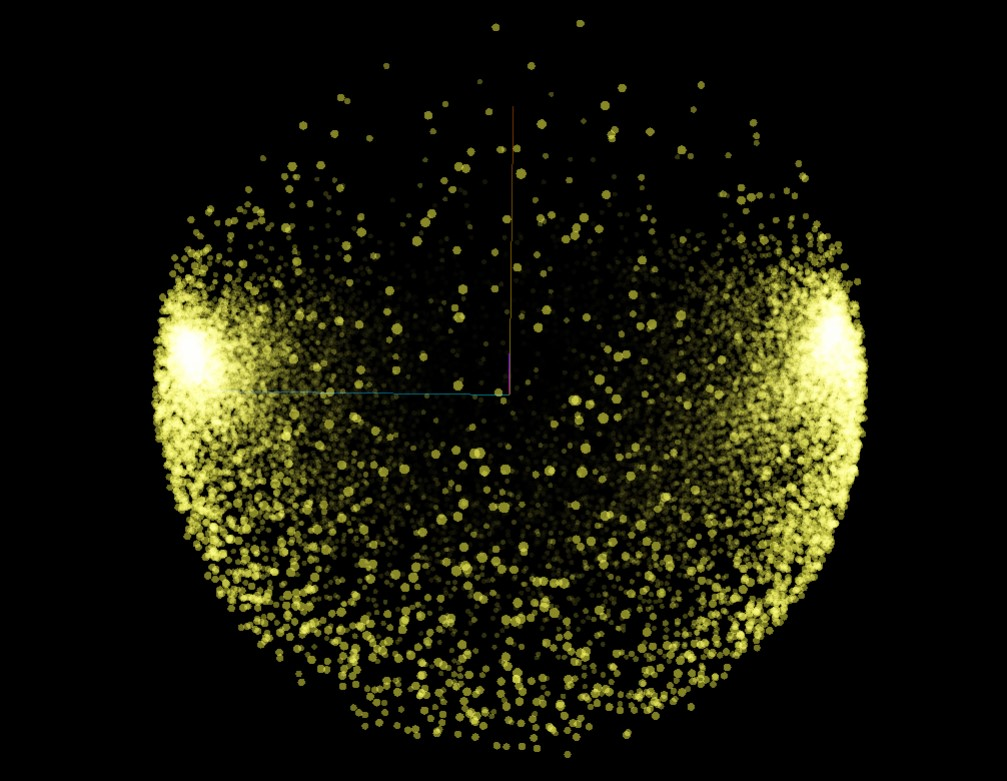

We notice how the three dimensional PCA (out of scope) space consists of two clusters on an axis.<br><br>
It is easily interpreted that one cluster has the words that have positive effects and the other cluster has the words with negative effects.<br><br>
Alright, now let's test our model by manually entering reviews ourselves and see how the model performs!

In [20]:
def predict_sentiment(text, model):
  testing_sentences=[]
  testing_sentences.append(text)
  testing_sentences = np.array(testing_sentences)
  testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
  testing_padded = pad_sequences(testing_sequences, maxlen=max_length)
  result = model.predict(testing_padded)
  if result>0.5:
    return "Liked it!", result
  else:
    return "Didn't like it.", result  
  

Let's provide a short negative review.

In [21]:
predict_sentiment("This movie was a waste of time!", model)

("Didn't like it.", array([[0.04997756]], dtype=float32))

Okay so our model got it right!<br>
<br>
Now let's try a short positive review.

In [22]:
predict_sentiment("This movie was terrific! I had a great time!", model)

('Liked it!', array([[0.96404606]], dtype=float32))

Awesome! The model got this one too!